In [5]:
from keras.models import Sequential 
from keras.models import load_model
from keras import layers
from keras.preprocessing.image import ImageDataGenerator, image_dataset_from_directory, load_img, img_to_array
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np
import os 


In [139]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_SIZE = (IMAGE_HEIGHT,IMAGE_WIDTH)
IMAGE_CHANNELS = 3
BATCH_SIZE = 32
CATEGORIES = ['mask_weared_incorrect','with_mask','without_mask']
DIRECTORY = "Dataset"
DROP_RATE = 0.25

In [140]:
#2994 images per folder
for category in CATEGORIES:
    print(len(os.listdir("Dataset/"+category)))

2994
2994
2994


In [141]:
#combine data into single dataset
filenames = []
labels = []
for category in CATEGORIES:
    path = os.path.join(DIRECTORY,category)
    names = os.listdir(path)
    for name in names:
        filenames.append(os.path.join(path,name))
        labels.append(category)
df = pd.DataFrame({
    'filename' : filenames,
    'label': labels
})

In [142]:
df.label.value_counts()

mask_weared_incorrect    2994
without_mask             2994
with_mask                2994
Name: label, dtype: int64

In [143]:
num_samples = df.shape[0]
df.shape

(8982, 2)

Text(0.5, 0, 'with_mask')

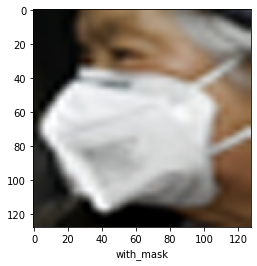

In [144]:
#visualise image
num = random.randint(1,num_samples)
filename,label = df.iloc[num]
img = load_img(filename)
plt.imshow(img)
plt.xlabel(label)

In [145]:
#shuffle data
df = df.sample(frac=1).reset_index(drop=True)

In [146]:
#split training and testing data
train_df, test_df = train_test_split(df,test_size=0.1,shuffle=True,random_state=42)

In [147]:
train_df.shape

(8083, 2)

In [148]:
test_df

filename                  label
7588           Dataset\without_mask\1959.png           without_mask
93    Dataset\mask_weared_incorrect\1197.png  mask_weared_incorrect
761                Dataset\with_mask\823.png              with_mask
8824              Dataset\with_mask\1896.png              with_mask
8458              Dataset\with_mask\2427.png              with_mask
...                                      ...                    ...
2458            Dataset\without_mask\491.png           without_mask
4192              Dataset\with_mask\1533.png              with_mask
7514           Dataset\without_mask\1613.png           without_mask
1195              Dataset\with_mask\1240.png              with_mask
3434              Dataset\with_mask\2221.png              with_mask

[899 rows x 2 columns]

In [149]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

In [150]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [151]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col = "filename",
    y_col = "label",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    subset="training"
)

Found 6467 validated image filenames belonging to 3 classes.


In [152]:
validation_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="label",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    subset="validation"
)

Found 1616 validated image filenames belonging to 3 classes.


In [153]:
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col="filename",
    y_col="label",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    shuffle=False
)

Found 899 validated image filenames belonging to 3 classes.


In [154]:
model = Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(DROP_RATE))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(DROP_RATE))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(DROP_RATE))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(DROP_RATE))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(DROP_RATE))

model.add(layers.Dense(3, activation='softmax'))

In [155]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy",
    patience=3,
    verbose=1,
    factor=0.75,
    min_lr=0.00001
)
callbacks = [earlystop, learning_rate_reduction]

In [156]:
model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["accuracy"])

In [157]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)       

In [158]:
history = model.fit(
    train_generator, 
    validation_data=validation_generator, 
    callbacks=callbacks, 
    epochs=50,
    verbose=1
    )

Epoch 1/50
203/203 [==============================] - 71s 334ms/step - loss: 0.7401 - accuracy: 0.7539 - val_loss: 2.7930 - val_accuracy: 0.3391
Epoch 2/50
203/203 [==============================] - 34s 165ms/step - loss: 0.4458 - accuracy: 0.8355 - val_loss: 2.4982 - val_accuracy: 0.5056
Epoch 3/50
203/203 [==============================] - 35s 174ms/step - loss: 0.3710 - accuracy: 0.8611 - val_loss: 0.6324 - val_accuracy: 0.7568
Epoch 4/50
203/203 [==============================] - 32s 157ms/step - loss: 0.3309 - accuracy: 0.8756 - val_loss: 0.4626 - val_accuracy: 0.8193
Epoch 5/50
203/203 [==============================] - 32s 158ms/step - loss: 0.3213 - accuracy: 0.8772 - val_loss: 0.5034 - val_accuracy: 0.8007
Epoch 6/50
203/203 [==============================] - 32s 157ms/step - loss: 0.2738 - accuracy: 0.8922 - val_loss: 0.6069 - val_accuracy: 0.7550
Epoch 7/50
203/203 [==============================] - 32s 156ms/step - loss: 0.2722 - accuracy: 0.8984 - val_loss: 0.4662 - val_ac

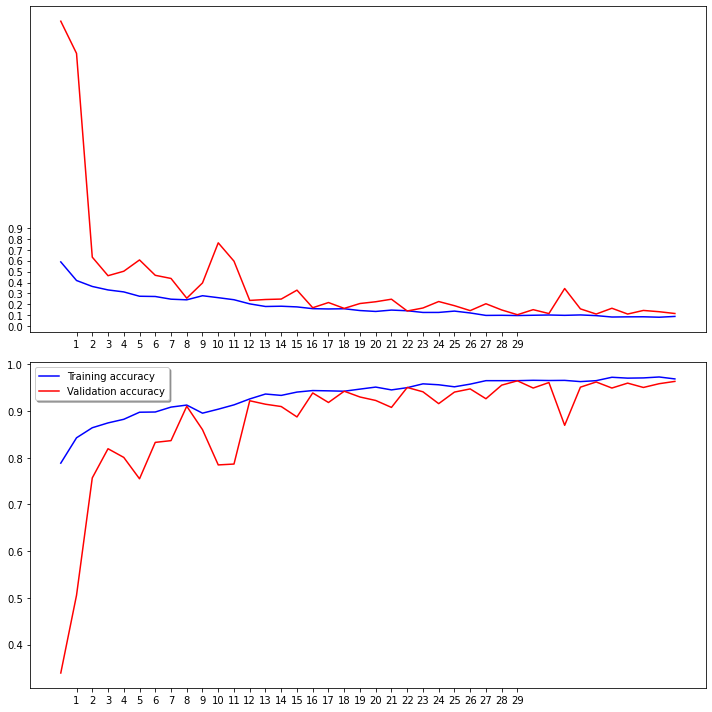

In [159]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,10))
ax1.plot(history.history['loss'],color='b',label="Training loss")
ax1.plot(history.history['val_loss'],color='r',label="Validation loss")
ax1.set_xticks(np.arange(1, 50, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'],'b',label='Training accuracy')
ax2.plot(history.history['val_accuracy'],'r',label='Validation accuracy')
ax2.set_xticks(np.arange(1, 50, 1))
legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [160]:
Model_Results = model.evaluate(test_generator)

29/29 [==============================] - 4s 129ms/step - loss: 0.0501 - accuracy: 0.9833


In [161]:
Model_Results

[0.050140973180532455, 0.9833148121833801]

In [162]:
prediction = model.predict(test_generator)

In [163]:
prediction[0:10]

array([[1.1780604e-07, 1.1987395e-04, 9.9987996e-01],
       [9.9945980e-01, 8.5228472e-05, 4.5500748e-04],
       [5.3203401e-08, 9.9999428e-01, 5.7593620e-06],
       [8.8036013e-06, 9.9990630e-01, 8.4882384e-05],
       [5.4302841e-04, 9.9826652e-01, 1.1905492e-03],
       [9.9999189e-01, 5.2972255e-06, 2.8746899e-06],
       [9.7048908e-01, 5.7909107e-05, 2.9452929e-02],
       [9.9996996e-01, 1.5508742e-05, 1.4531884e-05],
       [5.3730193e-03, 9.9414659e-01, 4.8036801e-04],
       [1.7662311e-04, 3.2837983e-05, 9.9979061e-01]], dtype=float32)

In [164]:
prediction = prediction.argmax(axis=-1)

In [165]:
prediction[:10]

array([2, 0, 1, 1, 1, 0, 0, 0, 1, 2], dtype=int64)

PREDICTION MEANINGS


0:mask_weared_incorrect

1:with_mask

2:without_mask

In [166]:
mapping = {0:"mask weared incorrectly",1:"with mask",2:"without mask"}

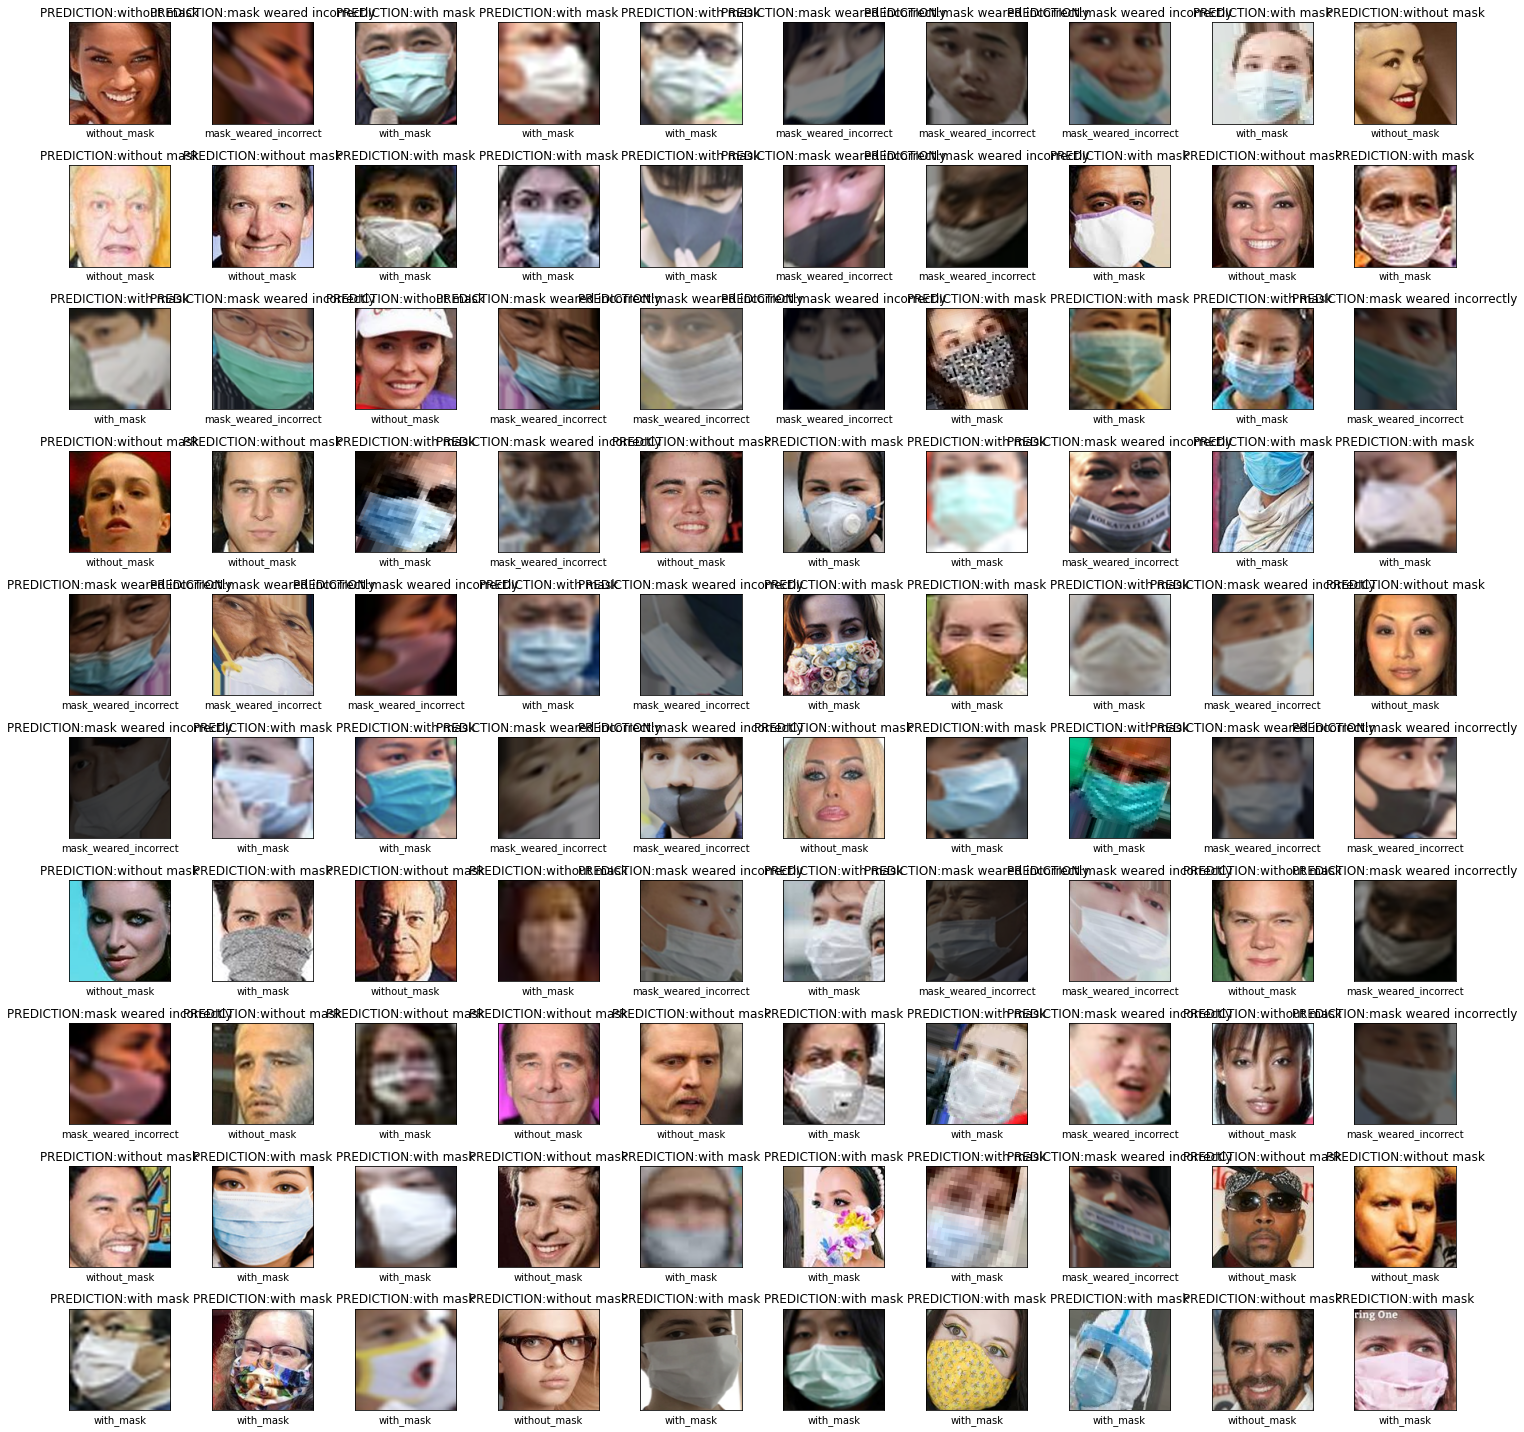

In [167]:
fig, axes = plt.subplots(nrows=10,ncols=10,figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(load_img(test_df.filename.iloc[i]))
    ax.set_title(f"PREDICTION:{mapping[prediction[i]]}")
    ax.set_xlabel(test_df.label.iloc[i])
plt.tight_layout()
plt.show()

In [168]:
model.save("model_nn")

INFO:tensorflow:Assets written to: third\assets


In [12]:
#using cv2 to test it works
m = load_model("model_nn")

import cv2
test = cv2.imread("Dataset/mask_weared_incorrect/1.png")
test = cv2.resize(test,(128,128))
test = test[...,::-1].astype(np.float32) / 255.0
test = np.reshape(test,(1,128,128,3))
m.predict(test)

array([[9.9999177e-01, 8.1248718e-06, 1.6898758e-07]], dtype=float32)